# Lab 3 Assignment
__Authors__: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

***
## Business Understanding  
<font color=blue>Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?</font>

Washington, D.C. is the capital of the United States. Washington's population is approaching 700,000 people, and has been growing since 2000 following a half-century of population decline. The city is highly segregated and features a high cost of living. In 2017, the average price of a single family home in the district was $649,000. 

Understanding the various features and similarities between the various neighborhoods provides important insights into the housing market within the district. This analysis will serve as means for a real estate agency to develop profiles of the various wards in DC. By better understanding the housing characteristics of the different wards they can better recommend specific areas to begin there search based on the clients needs.

We will measure effectivenss of different clustering algorithms to seperate various types of homes from the DC data set. For example single family homes on large plots of land should be considered as a different type of home than downtown flat in a 10 story building. The process of evaluating will be based on two criteria.

1) Silhouette Coefficient and other statistical measures to determing the correct amount of clusters to use and our ability to seperate them into distinct categories.

2) Manual evaluation of the observations to identify the similarity betweent he various clusters based on the our own ability to differentiate between different styles of homes.

***
## Data Understanding 1
<font color=blue>Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?</font>

For this data we will be reading in and joining two data sets from Kaggle https://www.kaggle.com/christophercorrea/dc-residential-properties
*raw_residential_data.csv* : 
The Computer Assisted Mass Appraisal - Residential data contains attribution on housing characteristics for residential properties, and was created as part of the DC Geographic Information System (DC GIS) for the D.C. Office of the Chief Technology Officer (OCTO) and participating D.C. government agencies.

*raw_address_points.csv* :
The raw address points data contains locations and attributes of Address points as of July 2018. This file is part of the Master Address Repository (MAR) for the D.C. Office of the Chief Technology Officer and DC Department of Consumer and Regulatory Affairs . It contains the standardized addresses in the District of Columbia which are typically placed on the buildings.

The second dataset will only be used as we interpret results to better understands how the various clusters of DC homes relates to the various DC neighborhoods and if any insights can be uncovered.

In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('Data/raw_residential_data.csv')
df1.info()

df2 = pd.read_csv('Data/raw_address_points.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107154 entries, 0 to 107153
Data columns (total 39 columns):
OBJECTID             107154 non-null int64
SSL                  107154 non-null object
BATHRM               107127 non-null float64
HF_BATHRM            107126 non-null float64
HEAT                 107127 non-null float64
HEAT_D               107127 non-null object
AC                   107127 non-null object
NUM_UNITS            107127 non-null float64
ROOMS                107110 non-null float64
BEDRM                107123 non-null float64
AYB                  107141 non-null float64
YR_RMDL              49446 non-null float64
EYB                  107154 non-null int64
STORIES              107080 non-null float64
SALEDATE             107154 non-null object
PRICE                87866 non-null float64
QUALIFIED            107154 non-null object
SALE_NUM             107154 non-null int64
GBA                  107154 non-null int64
BLDG_NUM             107154 non-null int64
STYLE 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147300 entries, 0 to 147299
Data columns (total 52 columns):
X                             147300 non-null float64
Y                             147300 non-null float64
OBJECTID_12                   147300 non-null int64
SITE_ADDRESS_PK               147300 non-null int64
ADDRESS_ID                    147300 non-null int64
STATUS                        147300 non-null object
SSL                           146935 non-null object
TYPE_                         147300 non-null object
ENTRANCETYPE                  147300 non-null object
ADDRNUM                       145396 non-null float64
ADDRNUMSUFFIX                 2262 non-null object
STNAME                        147300 non-null object
STREET_TYPE                   147300 non-null object
QUADRANT                      147300 non-null object
CITY                          147300 non-null object
STATE                         147300 non-null object
FULLADDRESS                   145396 non-nu

From what we can see we have data on 107,154 different residential. They are measured on 39 different measures where applicable. 

Several of the features are dummy variables of the other and are labeled with "D" we will use the D variables to make one hot endoding simpler to read. A dictionary of those dummy variables can be found in the appendix along with a description of each of the variables.

Below we subset our variables of interest and assess the amount of NULL values and potential outliers that need to get addressed.


In [2]:
#Identify all categorical variables
categories = [['CNDTN_D','CNDTN'],['HEAT_D','HEAT'],['STYLE_D','STYLE'],['STRUCT_D','STRUCT'],['GRADE_D','GRADE'],['ROOF_D','ROOF'],['EXTWALL_D','EXTWALL'],['INTWALL_D','INTWALL']]
cat_drop = []
for c in categories:
    round(df1[c[1]])
    cat_drop.append(c[0])
    
# eliminate redundant dummy variables
df1.drop(cat_drop, inplace=True, axis=1)
df1.head()


,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM
0,1001,0152 0133,4.0,0.0,7.0,Y,2.0,8.0,4.0,1910.0,...,6.0,4.0,14.0,6.0,6.0,2.0,5.0,24,1680,2018-07-22T18:01:43.000Z
1,1002,0152 0134,3.0,1.0,7.0,Y,2.0,11.0,5.0,1898.0,...,6.0,4.0,14.0,2.0,6.0,2.0,4.0,24,1680,2018-07-22T18:01:43.000Z
2,1003,0152 0135,3.0,1.0,13.0,Y,2.0,9.0,5.0,1910.0,...,6.0,5.0,14.0,2.0,6.0,2.0,4.0,24,1680,2018-07-22T18:01:43.000Z
3,1004,0152 0136,3.0,1.0,13.0,Y,2.0,8.0,5.0,1900.0,...,6.0,4.0,14.0,2.0,6.0,2.0,3.0,24,1680,2018-07-22T18:01:43.000Z
4,1005,0152 0138,2.0,1.0,7.0,Y,1.0,11.0,3.0,1913.0,...,6.0,4.0,14.0,13.0,6.0,1.0,0.0,13,2032,2018-07-22T18:01:43.000Z


In [3]:
print(df1.isnull().sum())

OBJECTID                 0
SSL                      0
BATHRM                  27
HF_BATHRM               28
HEAT                    27
AC                      27
NUM_UNITS               27
ROOMS                   44
BEDRM                   31
AYB                     13
YR_RMDL              57708
EYB                      0
STORIES                 74
SALEDATE                 0
PRICE                19288
QUALIFIED                0
SALE_NUM                 0
GBA                      0
BLDG_NUM                 0
STYLE                   27
STRUCT                  27
GRADE                   27
CNDTN                   27
EXTWALL                 27
ROOF                    27
INTWALL                 27
KITCHENS                28
FIREPLACES              28
USECODE                  0
LANDAREA                 0
GIS_LAST_MOD_DTTM        0
dtype: int64


Our data set is still 107,154 observations but now contains only 31 observations. However, we do see that there are several null values for various features. For each of the categorical or numeric features with 100 or fewer obs we will simply impute the missing values using the most common class or median value. However, the year remodeled, & price stand out and will probably need to be treated differently.

For the year remodeled we will assume that variable is missing when no remodels have been done to the home. Thus, converting the year to bins and treating the 57k with no remodel year as there own class. Clusters with a high proportion of these class homes may provides insights into homes ideal for contractors.

Considering the price is the price of the last sale. Considering the volatility of the housing market over time and inflation that we believe that feature could be misleading, so we will opt to leave it out of our analysis.

In addition to the price category we will also drop several other codes that we have deemed not useful.

In [4]:
bins = [0, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ['50+','50','40','30','20','10','0']
df1['YR_RMDL_ClASS'] = pd.cut(df1['YR_RMDL'], bins=bins, labels=labels)
df1['YR_RMDL_ClASS'] = df1['YR_RMDL_ClASS'].replace(np.nan, 'NONE', regex=True)

# eliminate unnecessary variables
df1.drop(['PRICE','QUALIFIED','BLDG_NUM','GRADE','CNDTN','EYB','USECODE','GIS_LAST_MOD_DTTM','YR_RMDL','SALEDATE'], inplace=True, axis=1)

In [5]:
df1.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GBA,STYLE,STRUCT,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,YR_RMDL_ClASS
0,1001,0152 0133,4.0,0.0,7.0,Y,2.0,8.0,4.0,1910.0,...,2522,7.0,7.0,14.0,6.0,6.0,2.0,5.0,1680,30
1,1002,0152 0134,3.0,1.0,7.0,Y,2.0,11.0,5.0,1898.0,...,2567,7.0,7.0,14.0,2.0,6.0,2.0,4.0,1680,10
2,1003,0152 0135,3.0,1.0,13.0,Y,2.0,9.0,5.0,1910.0,...,2522,7.0,7.0,14.0,2.0,6.0,2.0,4.0,1680,10
3,1004,0152 0136,3.0,1.0,13.0,Y,2.0,8.0,5.0,1900.0,...,2484,7.0,7.0,14.0,2.0,6.0,2.0,3.0,1680,10
4,1005,0152 0138,2.0,1.0,7.0,Y,1.0,11.0,3.0,1913.0,...,5255,7.0,8.0,14.0,13.0,6.0,1.0,0.0,2032,0


In [6]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

df = DataFrameImputer().fit_transform(df1)

int_col = ['BATHRM','HF_BATHRM','HEAT','NUM_UNITS','ROOMS','BEDRM','AYB','STORIES','STYLE','STRUCT',
           'EXTWALL','ROOF','INTWALL','KITCHENS','FIREPLACES','LANDAREA']

for i in int_col:
    df[i] = df[i].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107154 entries, 0 to 107153
Data columns (total 22 columns):
OBJECTID         107154 non-null int64
SSL              107154 non-null object
BATHRM           107154 non-null int64
HF_BATHRM        107154 non-null int64
HEAT             107154 non-null int64
AC               107154 non-null object
NUM_UNITS        107154 non-null int64
ROOMS            107154 non-null int64
BEDRM            107154 non-null int64
AYB              107154 non-null int64
STORIES          107154 non-null int64
SALE_NUM         107154 non-null int64
GBA              107154 non-null int64
STYLE            107154 non-null int64
STRUCT           107154 non-null int64
EXTWALL          107154 non-null int64
ROOF             107154 non-null int64
INTWALL          107154 non-null int64
KITCHENS         107154 non-null int64
FIREPLACES       107154 non-null int64
LANDAREA         107154 non-null int64
YR_RMDL_ClASS    107154 non-null object
dtypes: int64(19), object(3)

In [7]:
df.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GBA,STYLE,STRUCT,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,YR_RMDL_ClASS
0,1001,0152 0133,4,0,7,Y,2,8,4,1910,...,2522,7,7,14,6,6,2,5,1680,30
1,1002,0152 0134,3,1,7,Y,2,11,5,1898,...,2567,7,7,14,2,6,2,4,1680,10
2,1003,0152 0135,3,1,13,Y,2,9,5,1910,...,2522,7,7,14,2,6,2,4,1680,10
3,1004,0152 0136,3,1,13,Y,2,8,5,1900,...,2484,7,7,14,2,6,2,3,1680,10
4,1005,0152 0138,2,1,7,Y,1,11,3,1913,...,5255,7,8,14,13,6,1,0,2032,0


We now have a cleaned up set of 22 different features for over 107k homes with all the missing values imputed. Before we begin analysis and clustering of our data we will explore these variables a little further to understand any transformations that may be required or any outliers that need to be addressed.

Additional Outlier Vars that we determined need to be addressed:

*Stories > 200*

These are likely reporting errors as the there is a limit to the height of building in DC that would prevent any building being over 200 stories. This causes us to question any of the validity of the data in these observations, thus we will remove them from our data.

*AYB < 1500*

While it may be possible from some homes to be originally built prior to 1900, these earlier homes represent a very small proportion of our data. The majority of them have years reported as 50 or below. In order to help secure overall data quality we will remove those observations from our data. 

*Style > 25*

Style Dummy variables greater than 25 represent two 'Styles'. Outbuildings & Vacants, neither of which we want to consider in our analysis.

*Kitchens > 20*

As you can see below there is only a single home with > 20 kitchens and considering the other variables this appears to be a 
reprorting error and will be removed from analyis.

*Rooms > 100 or BedRooms > Rooms*

Based on the square footage for the one home with > 100 rooms its seems highly unlikely that that value is accurate. Additionally, any scenario where bedrooms is greater than rooms is impossible so we will not like to use these in our analysis as well.


***
## Data Understanding 2
<font color=blue>Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.</font>

Let explore our data a little further to better understand the features that may be of importance for our analysis. First we will try to understand some of the different Wards in our data.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


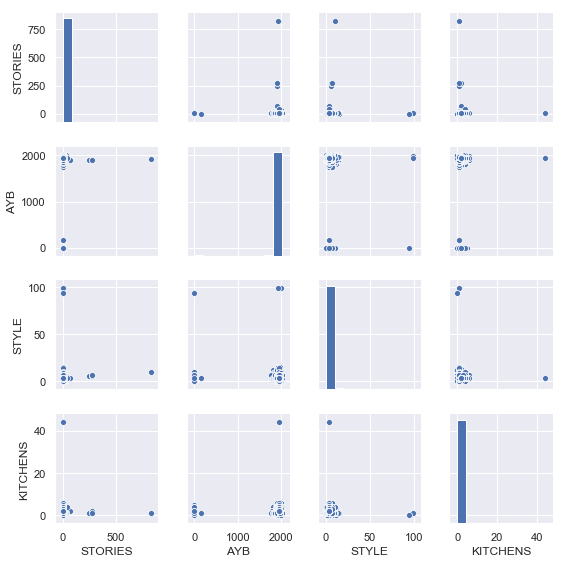

In [8]:
#Plots before outlier Removals
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plotVar = ['STORIES','AYB','STYLE','KITCHENS']

sns.pairplot(df[plotVar], size=2)

In [9]:
#removal false records
df = df[df.STORIES < 200]
df = df[df.AYB > 1500]
df = df[df.STYLE < 25]
df = df[df.KITCHENS < 20]
df = df[df.ROOMS < 100]
df = df[df.ROOMS >= df.BEDRM]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


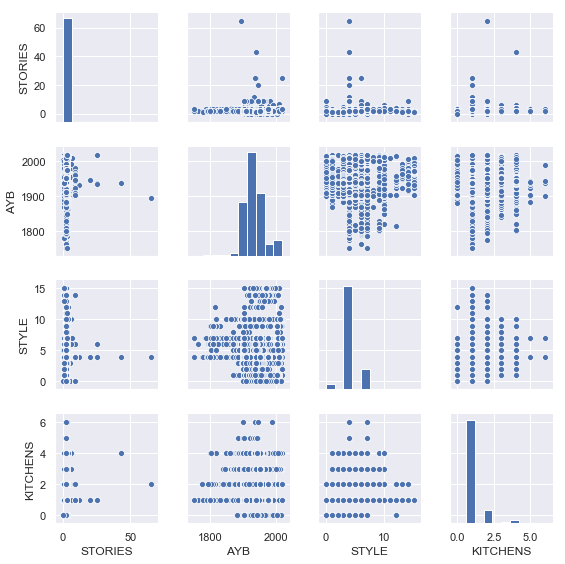

In [10]:
#plots after
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plotVar = ['STORIES','AYB','STYLE','KITCHENS']

sns.pairplot(df[plotVar], size=2)

In order to help the client understand the how the home types for the various neighborhoods or wards relate we have to join with data collected through a different source to get distinct location information related to these addresses. However, not all address information is available for all the homes in our set so for the purposes of this we will only consider homes which we have neighborhood information available.

In [11]:
# subset the variables of interest that we care about
df2 = df2.drop_duplicates(['SSL'], keep='last').set_index("SSL")[["LATITUDE","LONGITUDE","ASSESSMENT_NBHD","WARD"]]
# inner join the two datasets 
df = pd.merge(df,df2,how="inner",on="SSL")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105847 entries, 0 to 105846
Data columns (total 26 columns):
OBJECTID           105847 non-null int64
SSL                105847 non-null object
BATHRM             105847 non-null int64
HF_BATHRM          105847 non-null int64
HEAT               105847 non-null int64
AC                 105847 non-null object
NUM_UNITS          105847 non-null int64
ROOMS              105847 non-null int64
BEDRM              105847 non-null int64
AYB                105847 non-null int64
STORIES            105847 non-null int64
SALE_NUM           105847 non-null int64
GBA                105847 non-null int64
STYLE              105847 non-null int64
STRUCT             105847 non-null int64
EXTWALL            105847 non-null int64
ROOF               105847 non-null int64
INTWALL            105847 non-null int64
KITCHENS           105847 non-null int64
FIREPLACES         105847 non-null int64
LANDAREA           105847 non-null int64
YR_RMDL_ClASS      105847 

(Text(0.5,0,'Latitude'), Text(0,0.5,'Longitude'))

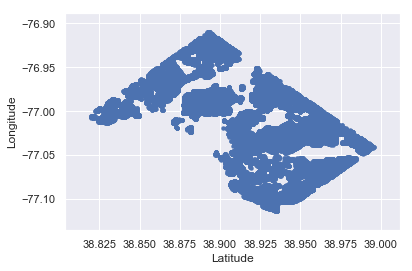

In [12]:
plt.figure()
plt.scatter(df.LATITUDE, df.LONGITUDE, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Latitude'), plt.ylabel('Longitude')

***
## Modeling and Evaluation  

<font color=DarkRed>Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results.</font>
    
#### Option A: Cluster Analysis  
<font color=DarkRed>  
__Train__: Perform cluster analysis using several clustering methods (adjust parameters).  
__Eval__: Use internal and/or external validation measures to describe and compare the clusterings and the clusters— how did you determine a suitable number of clusters for each method?  
__Visualize__: Use tables/visualization to discuss the found results. Explain each visualization in detail.  
__Summarize__: Describe your results. What findings are the most interesting and why?</font>  

#### Option B: Association Rule Mining  
<font color=DarkRed>  
__Train__: Create frequent itemsets and association rules (adjust parameters).  
__Eval__: Use several measure for evaluating how interesting different rules are.  
__Visualize__: Use tables/visualization to discuss the found results.  
__Summarize__: Describe your results. What findings are the most compelling and why? 
</font>  

#### Option C: Collaborative Filtering  
<font color=DarkRed>  
__Train__: Create user-item matrices or item-item matrices using collaborative filtering (adjust parameters).  
__Eval__: Determine performance of the recommendations using different performance measures (explain the ramifications of each measure).  
__Visualize__: Use tables/visualization to discuss the found results. Explain each visualization in detail.  
__Summarize__: Describe your results. What findings are the most compelling and why? 
</font>

***
## Modeling and Evaluation 1
<font color=blue>Train and adjust parameters</font>

***
## Modeling and Evaluation 2
<font color=blue>Evaluate and Compare</font>  

***
## Modeling and Evaluation 3
<font color=blue>Visualize Results</font>

***
## Modeling and Evaluation 4  
<font color=blue>Summarize the Ramifications</font>  
Blah blah.   

***
## Deployment
<font color=blue>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</font>  
Blah derper blah blah blah.  

***
## Exceptional Work  
<font color=blue>You have free reign to provide additional analyses or combine analyses.</font>  

Blah blah. Blah blah blah BLAH!  

***
## Appendix 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105847 entries, 0 to 105846
Data columns (total 26 columns):
OBJECTID           105847 non-null int64
SSL                105847 non-null object
BATHRM             105847 non-null int64
HF_BATHRM          105847 non-null int64
HEAT               105847 non-null int64
AC                 105847 non-null object
NUM_UNITS          105847 non-null int64
ROOMS              105847 non-null int64
BEDRM              105847 non-null int64
AYB                105847 non-null int64
STORIES            105847 non-null int64
SALE_NUM           105847 non-null int64
GBA                105847 non-null int64
STYLE              105847 non-null int64
STRUCT             105847 non-null int64
EXTWALL            105847 non-null int64
ROOF               105847 non-null int64
INTWALL            105847 non-null int64
KITCHENS           105847 non-null int64
FIREPLACES         105847 non-null int64
LANDAREA           105847 non-null int64
YR_RMDL_ClASS      105847 

- OBJECTID: Auto-generated internal unique ID
- SSL: Square, suffix, lot ID
- BATHRM: Number of full bathrooms
- HF_BATHRM: Number of half bathrooms (no shower or tub)
- HEAT: Heating code
    - 0: No Data
    - 1: Forced Air
    - 2: Air-Oil
    - 3: Wall Furnace
    - 4: Electric Rad
    - 5: Elec Base Brd
    - 6: Water Base Brd
    - 7: Warm Cool
    - 8: Ht Pump
    - 9: Evp Cool
    - 10: Air Exchng
    - 11: Gravity Furnac
    - 12: Ind Unit
    - 13: Hot Water Rad
- AC: Air conditioning (Y/N)
- NUM_UNITS: Number of units
- ROOMS: Number of rooms
- BEDRM: Number of bedrooms
- AYB: The earliest time the main portion of the building was built. It is not affected by subsequent construction.
- STORIES: Stories
- SALE_NUM: Sale number
- GBA: Gross building area in square feet
- STYLE: Style code
    - 0: Default
    - 1: 1 Story
    - 2: 1.5 Story Unfin
    - 3: 1.5 Story Fin
    - 4: 2 Story
    - 5: 2.5 Story Unfin
    - 6: 2.5 Story Fin
    - 7: 3 Story
    - 8: 3.5 Story
    - 9: 3.5 Story Fin
    - 10: 4 Story
    - 11: 4.5 Story Unfin
    - 12: 4.5 Story Fin
    - 13: Bi-Level
    - 14: Split Level
    - 15: Split Foyer
    - 94: Outbuildings
    - 99: Vacant
- STRUCT: Structure code
    - 0: Default
    - 1: Single
    - 2: Multi
    - 4: Town End
    - 5: Town Inside
    - 6: Row End
    - 7: Row Inside
    - 8: Semi-Detached
    - 13: Vacant Land
- EXTWALL: Exterior wall code
    - 0: Default              
    - 1: Plywood
    - 2: Hardboard
    - 3: Metal Siding
    - 4: Vinyl Siding
    - 5: Stucco
    - 6: Wood Siding
    - 7: Shingle
    - 8: SPlaster
    - 9: Rustic Log
    - 10: Brick Veneer
    - 11: Stone Veneer
    - 12: Concrete Block
    - 13: Stucco Block
    - 14: Common Brick
    - 15: Face Brick
    - 16: Adobe
    - 17: Stone
    - 18: Concrete
    - 19: Aluminum
    - 20: Brick/Stone
    - 21: Brick/Stucco
    - 22: Brick/Siding
    - 23: Stone/Stucco
    - 24: Stone/Siding
- ROOF: Roof type code
    - 0: Typical
    - 1: Comp Shingle
    - 2: Built Up
    - 3: Shingle
    - 4: Shake
    - 5: Metal- Pre
    - 6: Metal- Sms
    - 7: Metal- Cpr
    - 8: Composition Ro
    - 9: Concrete Tile
    - 10: Clay Tile
    - 11: Slate
    - 12: Concrete
    - 13: Neopren
    - 14: Water Proof
    - 15: Wood- FS
- INTWALL: Interior wall code
    - 0: Default
    - 1: Resiliant
    - 2: Carpet
    - 3: Wood Floor
    - 4: Ceramic Tile
    - 5: Terrazo
    - 6: Hardwood
    - 7: Parquet
    - 8: Vinyl Comp
    - 9: Vinyl Sheet
    - 10: Lt Concrete
    - 11: Hardwood/Carp
- KITCHENS: Number of kitchens
- FIREPLACES: Number of fireplaces
- LANDAREA: Land area of property in square feet
- LATITUDE: Lattitude of address
- LONGITUDE: Longitude of Address
- ASSESSMENT_NBHD: DC Neighborhood
- WARD: DC Wards

In [14]:
df.groupby(['WARD']).OBJECTID.count()

WARD
Ward 1     8014
Ward 2     5958
Ward 3    14362
Ward 4    20235
Ward 5    17969
Ward 6    15775
Ward 7    14845
Ward 8     8689
Name: OBJECTID, dtype: int64

In [15]:
df.groupby(['ASSESSMENT_NBHD']).OBJECTID.count()

ASSESSMENT_NBHD
16th Street Heights              1956
American University              2361
Anacostia                        1614
Barry Farms                       350
Berkley                           705
Brentwood                         733
Brightwood                       3724
Brookland                        5558
Burleith                          798
Capitol Hill                     3049
Central-tri 1                     174
Chevy Chase                      4741
Chillum                           857
Cleveland Park                   1083
Colonial Village                  627
Columbia Heights                 5164
Congress Heights                 3770
Crestwood                         765
Deanwood                         5626
Eckington                        1742
Foggy Bottom                      252
Forest Hills                      810
Fort Dupont Park                 3138
Fort Lincoln                      609
Foxhall                           366
Garfield                          